# ITI110 Project: Energy Consumption Forecasting

Student ID: 22A187U<br>
Name : Carel Teoh Beng Imm

Contents: <br>
> 1. Data Cleaning And Normalization<br>
> 2. Model Building and Training<br>
> 3. Evaluation and Visualization<br>
> 4. Deployment

In [ ]:
# Clone the tcn repository
!git clone https://github.com/philipperemy/keras-tcn.git
!pip install ./keras-tcn

!pip install tensorflow-addons

Cloning into 'keras-tcn'...
remote: Enumerating objects: 1940, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1940 (delta 59), reused 86 (delta 52), pack-reused 1821
Receiving objects: 100% (1940/1940), 5.85 MiB | 18.79 MiB/s, done.
Resolving deltas: 100% (1017/1017), done.
Processing ./keras-tcn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.2 MB/s eta 0:00:00
  Created wheel for keras-tcn: filename=keras_tcn-3.5.0-py3-none-any.whl size=13121 sha256=23982a1e49ae06710769aa87e98e1de80d58acfcc8c01e7b2042a34401ef9031
  Stored in directory: /root/.cache/pip/wheels/45/f1/7d/44a7fb612442c8f9ab3c8e007ee2d33047a9c560d442ce9472
Successfully built keras-tcn


In [ ]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
#import keras_tuner as kt
import tensorflow as tf

# Data cleaning and normalization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
training_run_folder = '/content/drive/MyDrive/WIP training/training_run_folder'
df = pd.read_csv("/content/drive/MyDrive/WIP training/2.2 merged_aggregated_hourly_without_block_id.csv")

In [ ]:
df.isnull().sum()

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

In [ ]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])
# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]

,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


In [ ]:
df = df.drop([15758, 15759])

In [ ]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())

In [ ]:
df = df[['tstp','temperature', 'humidity', 'windSpeed', 'holiday','month','hour','avg_energy_per_lclid' ]]

# Create X new columns using past X timestamp data

In [ ]:
dataframe = df.loc[:,"avg_energy_per_lclid"]
dataset = dataframe.values
dataset = dataset.astype("float32")

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)



,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385
8,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538
9,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154


In [ ]:
# Merge the reframed columns with weather and time features

In [ ]:
reframed["month"] = df.month.values[7:]
reframed["hour"] = df.hour.values[7:]
reframed["temperature"] = df.temperature.values[7:]
reframed["humidity"] = df.humidity.values[7:]
reframed["windSpeed"] = df.windSpeed.values[7:]
reframed["holiday"] = df.holiday.values[7:]

reframed["tstp"] = df.tstp.values[7:]

In [ ]:
# reframed = reframed.drop(['holiday'], axis=1)

In [ ]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19855 entries, 7 to 19861
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   var1(t-7)    19855 non-null  float32       
 1   var1(t-6)    19855 non-null  float32       
 2   var1(t-5)    19855 non-null  float32       
 3   var1(t-4)    19855 non-null  float32       
 4   var1(t-3)    19855 non-null  float32       
 5   var1(t-2)    19855 non-null  float32       
 6   var1(t-1)    19855 non-null  float32       
 7   var1(t)      19855 non-null  float32       
 8   month        19855 non-null  int64         
 9   hour         19855 non-null  int64         
 10  temperature  19855 non-null  float64       
 11  humidity     19855 non-null  float64       
 12  windSpeed    19855 non-null  float64       
 13  holiday      19855 non-null  float64       
 14  tstp         19855 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(8), float64(4), int64(2

In [ ]:
reframed = reframed.reindex(["month","hour","temperature","humidity","windSpeed",'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'],axis=1)

In [ ]:
reframed

,month,hour,temperature,humidity,windSpeed,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,11,16,9.84,0.86,2.95,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385
8,11,17,9.14,0.92,2.58,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538
9,11,18,9.12,0.90,2.91,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154
10,11,19,9.07,0.93,3.06,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923
11,11,20,8.69,0.93,2.96,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,2,20,5.94,0.76,3.25,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360
19858,2,21,5.03,0.79,3.06,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011
19859,2,22,4.10,0.84,3.02,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121
19860,2,23,3.93,0.85,2.75,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [ ]:
train_rows = int(0.8*len(df))
train = reframed[:train_rows]
test = reframed[train_rows:]

print("dataset no. of rows: ", len(reframed))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

dataset no. of rows:  19855
train dataset no. of rows:  15889
test dataset no. of rows:  3966


In [ ]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

In [ ]:
X_train.shape

(15889, 12)

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(15889, 1, 12) (15889,) (3966, 1, 12) (3966,)


In [ ]:
def train_performance_visualization(model, input_data, actual, start_row, end_row):
    pred = model.predict(input_data)
    run_mae = mae(actual,pred)
    run_mape = mape(actual,pred)
    run_rmse = math.sqrt(mean_squared_error(actual,pred))
    print(f"MAE: {run_mae}")
    print(f"MAPE: {run_mape}")
    print(f"RMSE: {run_rmse}")
    plt.plot(actual[start_row:end_row], label='actual')
    plt.plot(pred[start_row:end_row], label='prediction')
    plt.title("Actual vs prediction")
    plt.legend()
    plt.show()

# Training Runs

In [ ]:
# # Clone the tcn repository
# !git clone https://github.com/philipperemy/keras-tcn.git
# !pip install ./keras-tcn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
np.random.seed(5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tcn import TCN
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Conv1D, Dense, Input, Lambda
from tensorflow.keras.layers import Conv1D
import pickle
import matplotlib.pyplot as plt


tcn_model = tf.keras.Sequential()

# Add the TCN layer with the same configurations as your original model
tcn_model.add(TCN(nb_filters=64, kernel_size=3, nb_stacks=2, dilations=[1,2], padding='causal', activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_test.shape[2])))

# Add Dropout after the TCN layer
tcn_model.add(tf.keras.layers.Dropout(0.2))

# Flatten the output of the TCN layer
tcn_model.add(tf.keras.layers.Flatten())

# Add the final Dense layer for regression
tcn_model.add(tf.keras.layers.Dense(1))

# Compile the model
tcn_model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.00001), metrics=[keras.metrics.MeanAbsoluteError()])


In [ ]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_run_folder + '/W_ResBlk_7d Run 9/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.2f}-val_MAE-{val_mean_absolute_error:4.2f}-loss-{val_loss:4.2f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

Epoch 1/300
497/497 [==============================] - 8s 11ms/step - loss: 0.3358 - mean_absolute_error: 0.3358 - val_loss: 0.1196 - val_mean_absolute_error: 0.1196
Epoch 2/300
497/497 [==============================] - 3s 7ms/step - loss: 0.2315 - mean_absolute_error: 0.2315 - val_loss: 0.0965 - val_mean_absolute_error: 0.0965
Epoch 3/300
497/497 [==============================] - 4s 7ms/step - loss: 0.1938 - mean_absolute_error: 0.1938 - val_loss: 0.0791 - val_mean_absolute_error: 0.0791
Epoch 4/300
497/497 [==============================] - 6s 13ms/step - loss: 0.1616 - mean_absolute_error: 0.1616 - val_loss: 0.0739 - val_mean_absolute_error: 0.0739
Epoch 5/300
497/497 [==============================] - 4s 8ms/step - loss: 0.1441 - mean_absolute_error: 0.1441 - val_loss: 0.0680 - val_mean_absolute_error: 0.0680
Epoch 6/300
497/497 [==============================] - 3s 7ms/step - loss: 0.1280 - mean_absolute_error: 0.1280 - val_loss: 0.0631 - val_mean_absolute_error: 0.0631
Epoch 7/

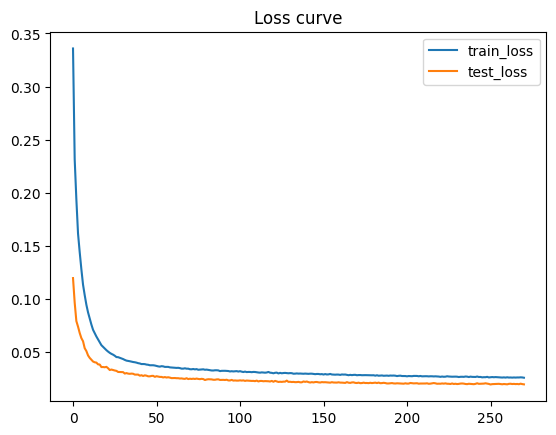

In [ ]:
# Train the model
history = tcn_model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

# Evaluation and Visualization

124/124 [==============================] - 1s 2ms/step
MAE: 0.019578068525149112
MAPE: 0.08662032892070484
RMSE: 0.026083642661744805


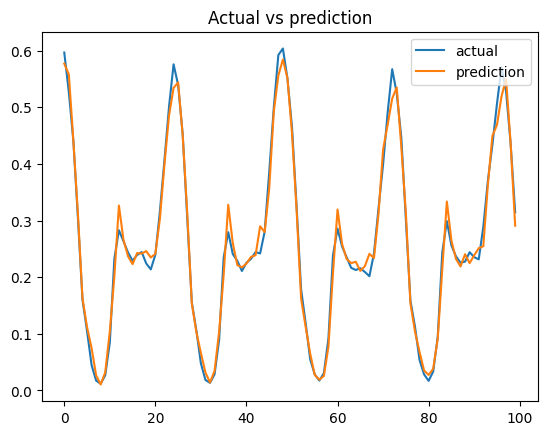

In [ ]:
train_performance_visualization(tcn_model, X_test, y_test, 0, 100)

497/497 [==============================] - 1s 2ms/step
MAE: 0.018703662841638862
MAPE: 3042385354.500415
RMSE: 0.027436893241455016


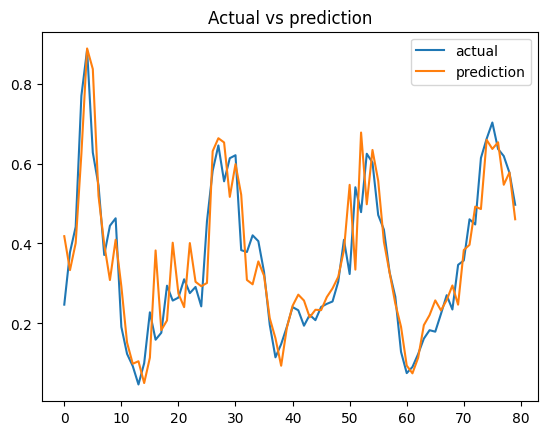

In [ ]:
train_performance_visualization(tcn_model, X_train, y_train, 0, 80)

In [ ]:
import pickle

filename = 'trained_modelW_ResBlk_7d Run 9.sav'
with open(filename, 'wb') as file:
    pickle.dump(tcn_model, file)


### ~ End of Training and Evaluation ~

In [ ]:
# Clone the tcn repository
!git clone https://github.com/philipperemy/keras-tcn.git
!pip install ./keras-tcn

!pip install tensorflow-addons

Cloning into 'keras-tcn'...
remote: Enumerating objects: 1940, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1940 (delta 59), reused 86 (delta 52), pack-reused 1821
Receiving objects: 100% (1940/1940), 5.85 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (1017/1017), done.
Processing ./keras-tcn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.1 MB/s eta 0:00:00
  Created wheel for keras-tcn: filename=keras_tcn-3.5.0-py3-none-any.whl size=13121 sha256=9e2975abc15b579dcf5a3dca384760f7fcf76374d11c421e7692cb7efd287eea
  Stored in directory: /root/.cache/pip/wheels/45/f1/7d/44a7fb612442c8f9ab3c8e007ee2d33047a9c560d442ce9472
Successfully built keras-tcn


### Loading the .h5 saved model file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Loading the .h5 saved model file
from keras.utils import custom_object_scope
from keras.models import load_model
from tcn import TCN

with custom_object_scope({'TCN': TCN}):
    model = load_model(r'/content/drive/MyDrive/WIP training/training_run_folder/W_ResBlk_7d Run 7/0237-MAE-0.02-val_MAE-0.02-loss-0.02.h5')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/WIP training/saved_models/

Mounted at /content/drive
/content/drive/MyDrive/WIP training/saved_models


In [2]:
!pip install streamlit
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


In [3]:
!pip install streamlit
# Clone the tcn repository
!git clone https://github.com/philipperemy/keras-tcn.git

# Install the tcn module
!pip install ./keras-tcn
from tcn import TCN, tcn_full_summary

fatal: destination path 'keras-tcn' already exists and is not an empty directory.
Processing ./keras-tcn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00
  Created wheel for keras-tcn: filename=keras_tcn-3.5.0-py3-none-any.whl size=13121 sha256=b15849c8fa853810b1cc08f1106df3f0a77d4ef4cc1a4cafaa09ffdc0071bfb0
  Stored in directory: /root/.cache/pip/wheels/1c/fd/e6/fa27fccd4075f49c9a3102a6a6fa2edca5abf3580ba0927bb5
Successfully built keras-tcn


In [4]:
import os
import streamlit as st
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Input, Lambda
from keras.models import load_model
from keras.utils import custom_object_scope
from tcn import TCN
import numpy as np
import pandas as pd
from keras.models import load_model
import tensorflow as tf

filepath = r"/content/drive/MyDrive/WIP training/saved_models/"
model_file = 'tcn_model_10.h5'
with custom_object_scope({'TCN': TCN}):
    #model = load_model(filepath + '0153-MAE-0.04-val_MAE-0.04-loss-0.04.h5')
    model = load_model(os.path.join(filepath, model_file))

In [5]:
# Example input data
input_data = [
  11, 10, 23.0, 1.99, 0.98, 0
]

# Convert the input data to a NumPy array
input_array = np.array(input_data)

# Reshape the input array to match the model's input shape
input_reshaped = input_array.reshape((1,) + input_array.shape)

### Make Predictions

In [6]:
predictions = model.predict(input_reshaped)

# Print the predictions
print(predictions)

1/1 [==============================] - 1s 1s/step
[[0.3575805]]


# Deployment of App To Streamlit

In [8]:
# Import streamlit
import streamlit as st
import numpy as np
import os
import streamlit as st
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Dense, Input, Lambda
from keras.models import load_model
from keras.utils import custom_object_scope
from tcn import TCN
import numpy as np
import pandas as pd
from keras.models import load_model
import tensorflow as tf

filepath = r"/content/drive/MyDrive/WIP training/saved_models/"
#filepath = r"C:\Users\Carel\Documents\Course NYP Specialist Diploma in Applied AI PDC2\SDAAI PDC2\ITI110 Project\App Deployment"
model_file = 'tcn_model_10.h5'
with custom_object_scope({'TCN': TCN}):
    #model = load_model(filepath + '0153-MAE-0.04-val_MAE-0.04-loss-0.04.h5')
    model = load_model(os.path.join(filepath, model_file))

# Create a Streamlit app
st.title('Your Energy Consumption Prediction App')

def predict():
  with st.sidebar:
    # Create sliders for each feature
    month = st.slider("Month of the year", min_value=1, max_value=12)
    hour = st.slider("Hour of the day", min_value=0, max_value=23)
    temperature = st.slider("Outside Temperature", min_value=0.0, max_value=50.0)
    humidity = st.slider("What is the Humidity", min_value=0.0, max_value=1.0)
    windSpeed = st.slider("Enter Windspeed", min_value=0.0, max_value=60.0)
    holiday = st.slider("Is it a Holiday", min_value=0, max_value=1)

    # Collect all features into a list
    input_data = [month, hour, temperature, humidity, windSpeed, holiday]

    # Convert the input data to a NumPy array
    input_data_as_numpy_array = np.asarray(input_data)
    input_array = np.array(input_data)

    # Reshape the input array to match the model's input shape
    input_reshaped = input_array.reshape((1,) + input_array.shape)

    # Make predictions
    predictions = model.predict(input_reshaped)

    return predictions

# Display the predictions on the Streamlit app
predictions = predict()

# Display the predictions on the Streamlit app
if st.button('Predict'):
    predictions = predict()
    st.write(predictions)



2024-02-25 09:56:36.660 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-02-25 09:56:36.663 Session state does not function when running a script without `streamlit run`


1/1 [==============================] - 0s 407ms/step


In [9]:
!streamlit run streamlit_app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.23.241.34:8501

  Stopping...
^C
